In [1]:
import numpy as np
import os

In [2]:
import tensorflow as tf

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [4]:
#gpu_fraction = 0.1
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [5]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [6]:
y_val = np.load('/srv/hd5/data/vprov/y_val.np.npy')
data_lpmt = np.load('/srv/hd5/data/vprov/lpmt_proj.np.npy')

In [7]:
data_lpmt = data_lpmt.reshape((*data_lpmt.shape, 1))

In [8]:
import keras
import keras.layers as L
from keras.models import Sequential

Using TensorFlow backend.


In [9]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [10]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7342820708004838026, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9885951591
 locality {
   bus_id: 2
   numa_node: 1
   links {
   }
 }
 incarnation: 10459996421049617109
 physical_device_desc: "device: 0, name: Tesla K40m, pci bus id: 0000:83:00.0, compute capability: 3.5"]

In [11]:
model = Sequential()
model.add(L.Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=256, kernel_size=(3,3),activation='relu'))
model.add(L.Flatten())
model.add(L.Dense(256, activation='relu'))
model.add(L.Dense(128, activation='relu'))
model.add(L.Dense(3))

In [12]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [13]:
model.build(input_shape=(None, 151,151,1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 149, 149, 128)     1280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [14]:
model.fit(data_lpmt[:30000], y_val[:30000], batch_size=32, epochs=10)

Epoch 1/10
10000/10000 [==============================] - 47s 5ms/step - loss: 10868712.9808
Epoch 2/10
10000/10000 [==============================] - 44s 4ms/step - loss: 2195968.0498
Epoch 3/10
10000/10000 [==============================] - 44s 4ms/step - loss: 1282199.5698
Epoch 4/10
10000/10000 [==============================] - 44s 4ms/step - loss: 922904.7975
Epoch 5/10
10000/10000 [==============================] - 44s 4ms/step - loss: 597748.4038
Epoch 6/10
10000/10000 [==============================] - 44s 4ms/step - loss: 469088.9893
Epoch 7/10
10000/10000 [==============================] - 44s 4ms/step - loss: 402184.7794
Epoch 8/10
10000/10000 [==============================] - 44s 4ms/step - loss: 339331.1719
Epoch 9/10
10000/10000 [==============================] - 43s 4ms/step - loss: 291601.6190
Epoch 10/10
10000/10000 [==============================] - 44s 4ms/step - loss: 273941.7331


In [15]:
model.fit(data_lpmt[:30000], y_val[:30000], 
          batch_size=32, epochs=100, 
          validation_data=(data_lpmt[:1000], y_val[:1000]))

Train on 10000 samples, validate on 1000 samples
Epoch 1/100
10000/10000 [==============================] - 46s 5ms/step - loss: 277009.9170 - val_loss: 358774.1773
Epoch 2/100
10000/10000 [==============================] - 45s 5ms/step - loss: 235342.5064 - val_loss: 158385.2583
Epoch 3/100
10000/10000 [==============================] - 45s 5ms/step - loss: 237433.5944 - val_loss: 217008.4484
Epoch 4/100
10000/10000 [==============================] - 45s 5ms/step - loss: 266821.6987 - val_loss: 145001.6776
Epoch 5/100
10000/10000 [==============================] - 45s 5ms/step - loss: 222008.6091 - val_loss: 209102.5775
Epoch 6/100
10000/10000 [==============================] - 45s 5ms/step - loss: 181750.0857 - val_loss: 157785.3810
Epoch 7/100
10000/10000 [==============================] - 45s 5ms/step - loss: 168908.7380 - val_loss: 188557.0017
Epoch 8/100
10000/10000 [==============================] - 45s 5ms/step - loss: 171007.6056 - val_loss: 140238.0722
Epoch 9/100
10000/10000

In [31]:
model.save_weights('10.02.2019.h5')

In [33]:
with open("model10.02.json", "w") as json_file:
    json_file.write(model.to_json())

In [34]:
from sklearn.metrics.pairwise import paired_euclidean_distances

In [35]:
# in mm
test_results = paired_euclidean_distances(model.predict(data_lpmt[:1000]), y_val[:1000])

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

(0, 500)

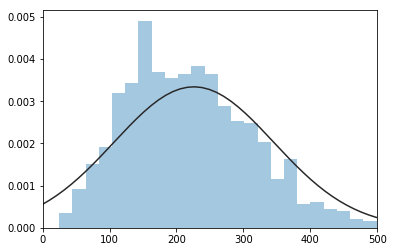

In [40]:
sns.distplot(test_results, kde=False, fit=stats.norm, bins=100)
plt.xlim(0,500)

In [42]:
test_results.mean()/10

22.590859191155875

In [46]:
results = model.predict(data_lpmt[:1000])

In [48]:
xs = results[:,0] - y_val[:1000][:,0]

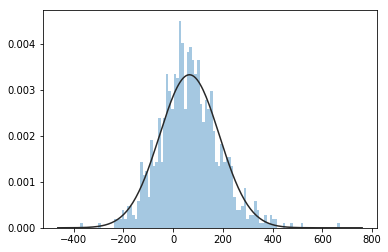

In [49]:
sns.distplot(xs, kde=False, fit=stats.norm, bins=100)

In [ ]:
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
## load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")
# 
## evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)

In [1]:
import pandas as pd

In [4]:
cs = pd.read_csv('log.csv', sep=';')

In [5]:
cs

,epoch,loss,val_loss
0,0,1.203077e+07,3.274920e+06
1,1,2.112775e+06,1.432360e+06
2,2,1.261646e+06,8.182227e+05
3,3,1.023242e+06,6.560844e+05
4,4,6.078493e+05,4.354411e+05
5,5,4.597292e+05,5.477911e+05
6,6,4.074644e+05,3.733454e+05
7,7,3.290443e+05,4.369745e+05
8,8,3.593889e+05,2.517203e+05
